# Notebook 3: Perform Dimensionality Reduction and Aggregate Track Data to Album Data

### Introduction

At this point, I have all the track features and genre information I need to start doing some dimensionality reduction and aggregation up to album level. I will scale the features, and then do PCA and aggregation to get the features at the album level.

In [2]:
import pandas as pd
import numpy as np
import pickle
import sys

sys.setrecursionlimit(1000000) #to allow pickling

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from matplotlib import pyplot as plt

from sklearn.metrics.pairwise import cosine_similarity

In [3]:
with open('../data/full.pickle', 'rb') as read_file:
    all = pickle.load(read_file)

### Prepare Data for Principal Components Analysis

In [4]:
#Remove unnecessary features
all.drop(['album_id', 'id', 'uri', 'track_href', 'analysis_url', 'type'], axis = 1, inplace = True)

In [5]:
all.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12163 entries, 0 to 12162
Data columns (total 16 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   album_artist      12163 non-null  object 
 1   genre             12163 non-null  object 
 2   track_id          12163 non-null  object 
 3   danceability      12163 non-null  float64
 4   energy            12163 non-null  float64
 5   key               12163 non-null  int64  
 6   loudness          12163 non-null  float64
 7   mode              12163 non-null  int64  
 8   speechiness       12163 non-null  float64
 9   acousticness      12163 non-null  float64
 10  instrumentalness  12163 non-null  float64
 11  liveness          12163 non-null  float64
 12  valence           12163 non-null  float64
 13  tempo             12163 non-null  float64
 14  duration_ms       12163 non-null  int64  
 15  time_signature    12163 non-null  int64  
dtypes: float64(9), int64(4), object(3)
memor

In [6]:
all_numvars = all.iloc[:, 3:]

In [7]:
#Scaling features for PCA - otherwise, all variance explained by first component.
scaler = StandardScaler()
scaler.fit(all_numvars)
scaled_numvars = scaler.transform(all_numvars)

In [8]:
#This is useful for the Flask app
# with open('../data/scaler_PCA.pickle', 'wb') as to_write:
#     pickle.dump(scaler, to_write)

### Determine Ideal Number of Components

In [8]:
#Infer number of components to use based on scree plot, explained variance
n_comp = 13
pca_scaled = PCA(n_components = n_comp)
pca_scaled.fit(scaled_numvars)
pcafeatures_scaled = pca_scaled.transform(scaled_numvars)

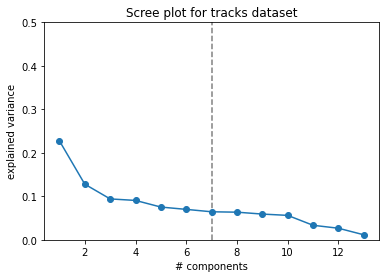

In [9]:
#Scree plot is not clear where to set threshold.
plt.plot(range(1,n_comp+1), pca_scaled.explained_variance_ratio_, marker='o')
plt.axvline(7, linestyle='--', color='gray', zorder=1)
plt.ylim(0, 0.5)
plt.xlabel('# components')
plt.ylabel('explained variance');
plt.title('Scree plot for tracks dataset');

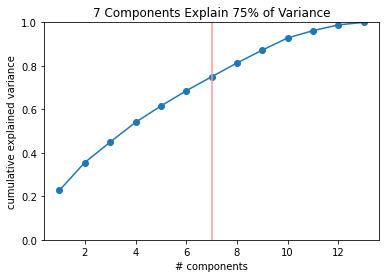

In [10]:
plt.plot(range(1, n_comp+1), np.cumsum(pca_scaled.explained_variance_ratio_), marker='o')
plt.axhline(0.75, linestyle='--', color='white', zorder=1)
plt.axvline(7, linestyle = '-', color = '#fb9a99')
plt.ylim(0, 1)
plt.xlabel('# components')
plt.ylabel('cumulative explained variance')
plt.title('7 Components Explain 75% of Variance')
plt.savefig('../../slide_img/PCAvar.png', transparent = True, dpi = 300);

### Perform Principal Components Analysis

In [11]:
#Based on the plot, it makes sense to use 7 components
n_comp = 7
pca_scaled7 = PCA(n_components = n_comp)
pca_scaled7.fit(scaled_numvars)
pcafeatures_scaled7 = pca_scaled7.transform(scaled_numvars)

In [12]:
# with open('../data/pca_scaled7.pickle', 'wb') as to_write:
#     pickle.dump(pca_scaled7, to_write)

### Combine with Album and Track Data

In [13]:
#Combine Components from PCA with album/track data
album_components = pd.concat([all.iloc[:, :2], pd.DataFrame(pcafeatures_scaled7)], axis = 1)

In [14]:
album_components

,album_artist,genre,0,1,2,3,4,5,6
0,album:Fetch the Bolt Cutters artist:Fiona Apple,"[art pop, chamber pop, indie pop, lilith, perm...",0.027304,-0.927792,1.307443,0.478314,-1.960776,0.540880,0.887651
1,album:Fetch the Bolt Cutters artist:Fiona Apple,"[art pop, chamber pop, indie pop, lilith, perm...",-1.842853,0.152583,-0.045206,-0.311621,-1.267901,-1.353938,-0.326658
2,album:Fetch the Bolt Cutters artist:Fiona Apple,"[art pop, chamber pop, indie pop, lilith, perm...",0.467639,-0.373565,-1.387450,-0.349999,0.206900,-0.956213,0.326950
3,album:Fetch the Bolt Cutters artist:Fiona Apple,"[art pop, chamber pop, indie pop, lilith, perm...",-0.511092,-0.996119,-1.480140,-0.381939,0.465950,-0.148116,0.298443
4,album:Fetch the Bolt Cutters artist:Fiona Apple,"[art pop, chamber pop, indie pop, lilith, perm...",-0.872851,-0.831828,2.797342,-0.225153,0.911177,0.365298,-0.402784
...,...,...,...,...,...,...,...,...,...
12158,album:American Gangster artist:Jay-Z,"[east coast hip hop, hip hop, pop rap, rap]",-2.112414,-0.840759,0.943058,1.362124,0.863960,1.500739,0.484315
12159,album:American Gangster artist:Jay-Z,"[east coast hip hop, hip hop, pop rap, rap]",-2.548832,-1.188720,1.299791,0.023726,0.740994,0.849779,0.752415
12160,album:American Gangster artist:Jay-Z,"[east coast hip hop, hip hop, pop rap, rap]",-2.422420,-0.445769,-0.014858,-0.713347,0.995249,0.839171,-0.614465
12161,album:American Gangster artist:Jay-Z,"[east coast hip hop, hip hop, pop rap, rap]",-2.261974,-1.527636,1.353009,-2.752949,2.472971,0.059978,-0.357239


In [22]:
# with open('../data/album_components.pickle', 'wb') as to_write:
#     pickle.dump(album_components, to_write)

### Aggregate Track Level to Album Level

In [3]:
# with open('data/album_components.pickle', 'rb') as read_file:
#     album_components = pickle.load(read_file)

In [15]:
components_by_album = album_components.groupby(['album_artist']).mean()

In [24]:
# with open('../data/components_by_album.pickle', 'wb') as to_write:
#     pickle.dump(components_by_album, to_write)

In [16]:
components_by_album

,0,1,2,3,4,5,6
album_artist,,,,,,,
album:'Sno Angel Like You artist:Howe Gelb,0.438139,-0.784680,-0.438254,-0.327055,0.078635,-0.284540,-0.079157
album:(After) [Live] artist:Mount Eerie,1.207571,0.160679,1.549967,-2.063090,1.285474,-0.502250,-0.686779
album:1988 artist:Blueprint,-1.816842,-0.681018,0.662502,-0.800187,0.943576,0.337509,0.323383
album:1991 [EP] artist:Azealia Banks,-1.470744,-0.908225,1.798601,0.827642,0.024125,0.001905,0.295101
"album:22, A Million artist:Bon Iver",2.002804,-0.743673,-0.167331,-0.308177,-0.165739,0.011133,-0.461295
...,...,...,...,...,...,...,...
album:uknowhatimsayin¿ artist:Danny Brown,-1.300955,-0.856804,-0.118266,-1.091831,1.149641,0.237218,0.147607
album:untitled unmastered. artist:Kendrick Lamar,-0.089747,-1.255659,1.259076,-1.188558,1.146739,-0.351176,0.346931
album:xx artist:The xx,-1.869674,0.348611,0.063678,-0.248160,0.130817,-0.011628,-0.371989
